In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import integrate
from scipy import interpolate

In [2]:
#Incluye la carpeta con el carchivo
path="/Users/namh2/OneDrive/Documentos/DOCTORADO/AJUSTES Y ERRORES LANE-EMDEN/Blok_McGaugh_Rubin_2001/"
data=np.loadtxt(path+"ESO3020120.dat")

In [3]:
RCr_data = np.array([row[1] for row in data])# galactocentric distance [kpc]
RCv_data = np.array([row[5] for row in data])# rotation velocity [km/s]
RCev_data = np.array([row[6] for row in data])# error in rotation velocity [km/s]

Text(0.5, 0, 'r[kpc]')

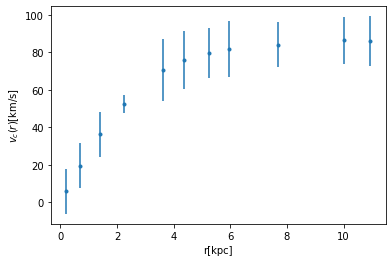

In [4]:
plt.errorbar(RCr_data,RCv_data,yerr=RCev_data,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

In [6]:
def Integrate(func,x0,y0,x,h):
    def RK4(func,x0,y0,h):
        K0 = h*func(x0,y0)
        K1 = h*func(x0 + 0.5*h, y0 + 0.5*K0)
        K2 = h*func(x0 + 0.5*h, y0 + 0.5*K1)
        K3 = h*func(x0 + h, y0 + K2)
        return (K0 + 2.*K1 + 2.*K2 + K3)/6.
    X = []
    Y = []
    X.append(x0)
    Y.append(y0)
    while y0[0] < 4.90000000000:
        y0 = y0 + RK4(func,x0,y0,h) 
        x0 = x0 + h 
        X.append(x0)
        Y.append(y0)
    return np.array(X),np.array(Y)

In [9]:
#Ecuaciones a resolver y[1]-->P, K-->constante, y[0]-->masa
def rhs(x,y):
    dy=np.zeros(2)
    dy[0]=4*np.pi*Gm*x**2*(y[1]/K)
    dy[1]=-Gp*y[0]/x**2*(y[1]/K)
    return dy

In [10]:
def model(data,v,X):
    V = []
    x=X
    RC=v*np.sqrt(G)
    Int_l = interpolate.interp1d(x,RC)  
    for i in range(len(data)):
        if data[i] < x[-1]:
            v=Int_l(data[i])
            V.append(v)
        else:
            #v=0. Es necesario cuando no toma todos los puntos
            v=np.sqrt(G*Y[:,0][-1]/(data[i]))
            V.append(v)
    return V,RC 

In [12]:
def Xi2(RCv_data,RCv_teo,RCev_data):
    xi=np.sum((RCv_data-RCv_teo)**2./(RCev_data)**2.)
    return xi

In [13]:
Gm=2.5188027*10**(-3)
Gp=0.499246*10**(-6)
G=4.258*10**(4)
Gv=1.24*10**(5)
y0=np.zeros(2)
h=0.001
x0=0.00001

In [40]:
#Se eligen los tamaños para el espacio de parámetros P vs K 
K_min=0.5*10**(-8)
K_max=5.*10**(-8)
Kvec=np.linspace(K_min,K_max,20)
p_0min=5.5*10**(-8)
p_0max=9.1*10**(-8)
p_0=np.linspace(p_0min,p_0max,20)

In [41]:
#Condiciones iniciales, antes de optimizar.
y0[0]=0.
y0[1]=p_0[0]
K=K_min

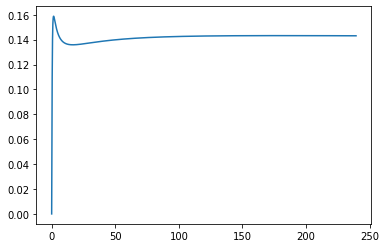

In [42]:
#Se realiza este paso para saber si tarda al integral las ecuaciones, en caso de tardar, se cambia la condicion y0[0] en RK4
X,Y=Integrate(rhs,x0,y0,10.,h)
v=np.sqrt(Y[:,0]/X)
plt.plot(X,v)

Text(0.5, 0, 'R[kpc]')

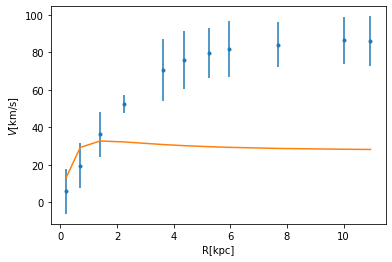

In [43]:
#Verificamos que la curva tome todos los puntos
V,RC=model(RCr_data,v,X)
plt.errorbar(RCr_data,RCv_data,yerr=RCev_data,fmt='.')
plt.plot(RCr_data,V)
plt.ylabel(r'$V$[km/s]')
plt.xlabel("R[kpc]")

In [44]:
%%time
#Se resuelve para crear un X^2 y obtener los valores que optimizan a X^2, se obtienen los mínimos
xi_minimo=10000
xi = np.zeros((len(p_0),len(Kvec)))
for l in range(0,len(Kvec)):
    K=Kvec[l]
    for i in range(0,len(p_0)):
        x0=0.00001
        y0[0]=0.
        y0[1]=p_0[i]
        X,Y=Integrate(rhs,x0,y0,10.,h)
        v=np.sqrt(Y[:,0]/X)
        V,RC=model(RCr_data,v,X)
        xi[i,l]=Xi2(RCv_data,V,RCev_data)
        if (xi[i,l] < xi_minimo):
            xi_minimo=xi[i,l]
            p0_minimo=p_0[i]
            K_minimo=Kvec[l]

Wall time: 10min 34s


In [45]:
rho0_minimo=p0_minimo/K_minimo
print(xi_minimo)
print(K_minimo)
print(p0_minimo)
print(rho0_minimo)

0.0419688235058533
3.342105263157895e-08
5.878947368421053e-08
1.7590551181102363


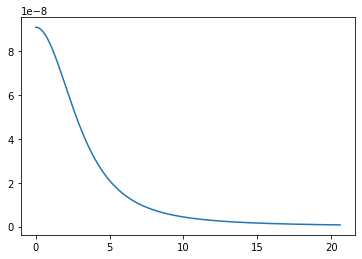

In [46]:
plt.plot(X,Y[:,1]) ## R vs P

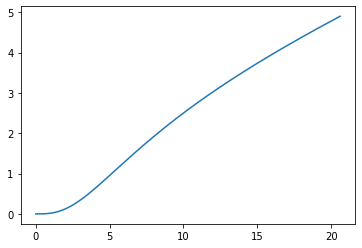

In [47]:
plt.plot(X,Y[:,0]) # R vs M

In [48]:
#Se crea una malla con los valores mínimos, nos darán el mejor ajuste
y0[0]=0.
y0[1]=p0_minimo
K=K_minimo

Text(0.5, 1.0, 'ESO3020120')

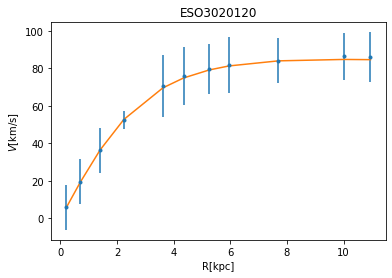

In [49]:
X,Y=Integrate(rhs,x0,y0,10.,h)
v=np.sqrt(Y[:,0]/X)
V,RC=model(RCr_data,v,X)
plt.errorbar(RCr_data,RCv_data,yerr=RCev_data,fmt='.')
plt.plot(RCr_data,V)

plt.ylabel(r'$V$[km/s]')
plt.xlabel("R[kpc]")
plt.title("ESO3020120")
#plt.savefig("RCESO3020120.pdf")  Para almacenar la figura

In [50]:
#se crea una malla para observar las regiones de confianza
xi2=np.zeros((len(p_0),len(Kvec)))
for i in range(0,len(p_0)):
    for j in range (0,len(Kvec)):
        xi2_minimo=10000
        if (xi[i,j] < xi2_minimo):
            xi2_minimo=xi[i,j]
            xi2[i,j]=xi[i,j]

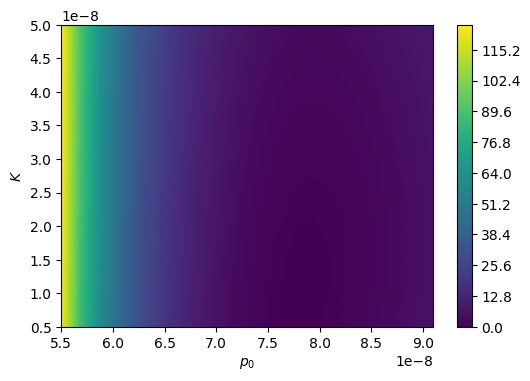

In [51]:
x,y = np.meshgrid(p_0,Kvec)
fig = plt.figure(dpi=100)
plt.contourf(x,y,xi2,400,cmap='viridis')
plt.xlabel(r'$p_0$')
plt.ylabel(r'$K$')
plt.colorbar();

In [52]:
#Creamos el arreglo que contiene todos los X^2 que se encuentren a una distancia \Delta X del mínimo 
diffxi2= np.zeros((len(p_0),len(Kvec)))
xicl = np.zeros((len(p_0),len(Kvec)))
for l in range(0,len(p_0)):
    for j in range(0,len(Kvec)):
        diffxi2[l,j]=xi2[l,j]-xi_minimo
        if ((diffxi2[l,j] ) <= 4.61):
            xicl[l,j]=diffxi2[l,j]

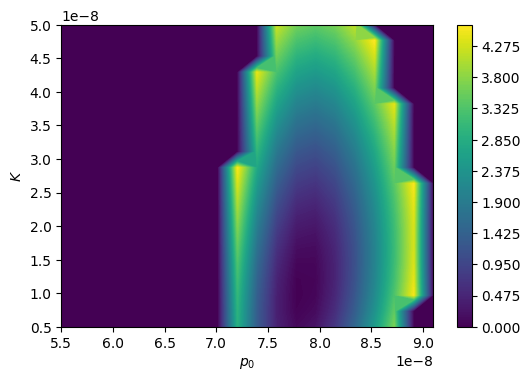

In [53]:
x,y = np.meshgrid(p_0,Kvec)
fig = plt.figure(dpi=100)
#plt.contourf(x,y,xicl,200,cmap='viridis')
plt.contourf(x,y,xicl,200,cmap='viridis')
plt.xlabel(r'$p_0$')
plt.ylabel(r'$K$')
plt.colorbar();

In [54]:
long=10000000
r=np.zeros(long)
kapa=np.zeros(long)
dx=np.zeros(long)
c=0
for i in range(0,len(p_0)):
    for j in range(0,len(Kvec)):
        r[c]=p_0[i]/Kvec[j]
        kapa[c]=Kvec[j]
        dx[c]=xicl[i,j]
        c=c+1 

In [55]:
#proyectar las variables en vectores para imprimir sus valores y gráficarlos
print(c)
vec1=np.zeros(c)
vec2=np.zeros(c)
vec3=np.zeros(c)
for i in range(0,len(vec1)):
    if (dx[i]!=0.0):
        vec1[i]=r[i]
        vec2[i]=kapa[i]
        vec3[i]=dx[i]

400


In [56]:
#Se crea el archivo para gráficar las regiones de confianza
np.savetxt("xi2ESO3020120.txt",np.transpose([vec1,vec2,vec3]))